# Predicting Medical Expense - Linear Regression with Scikit Learn

![](https://i.imgur.com/1EzyZvj.png)


## Problem Statement


ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, **you're tasked with creating an automated system to estimate the annual medical expenditure for new customers**, using information such as their age, sex, BMI, children, smoking habits and region of residence. 

Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to regulatory requirements, you must be able to explain why your system outputs a certain prediction.
 
You're given a [CSV file](https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv) containing verified historical data, consisting of the aforementioned information and the actual medical charges incurred by over 1300 customers.

Dataset source: https://github.com/stedy/Machine-Learning-with-R-datasets

In [1]:
from urllib.request import urlretrieve
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
# To display static plots on Github
# Comment it to make plots interactive
#import plotly.io as pio
#pio.renderers.default = "svg"
%matplotlib inline

## Downloading the Data

In [2]:
medical_charges_url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'

In [3]:
urlretrieve(medical_charges_url, 'medical.csv')

('medical.csv', <http.client.HTTPMessage at 0x15782c190>)

We can now create a Pandas dataframe using the downloaded file, to view and analyze the data.

In [4]:
medical_df = pd.read_csv('medical.csv')
medical_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer. 

Our objective is to find a way to estimate the value in the "charges" column using the values in the other columns. If we can do so for the historical data, then we should able to estimate charges for new customers too, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

Let's check the data type for each column.

In [5]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Looks like "age", "children", "bmi" ([body mass index](https://en.wikipedia.org/wiki/Body_mass_index)) and "charges" are numbers, whereas "sex", "smoker" and "region" are strings (possibly categories). None of the columns contain any missing values

Here are some statistics for the numerical columns:

In [6]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The ranges of values in the numerical columns seem reasonable too (no negative ages!), so we may not have to do much data cleaning or correction. The "charges" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.

## Exploratory Analysis and Visualization

The following settings will improve the default style and font sizes for our charts.

In [7]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive.

In [8]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

In [9]:
fig = px.histogram(medical_df, 
                   x='age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages. The uniform distribution might arise from the fact that there isn't a big variation in the [number of people of any given age](https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/) (between 18 & 64) in the USA.

#### Why are there twice as many as 18 - 19 yo in the dataset

Text(0.5, 1.0, 'Premium by Age')

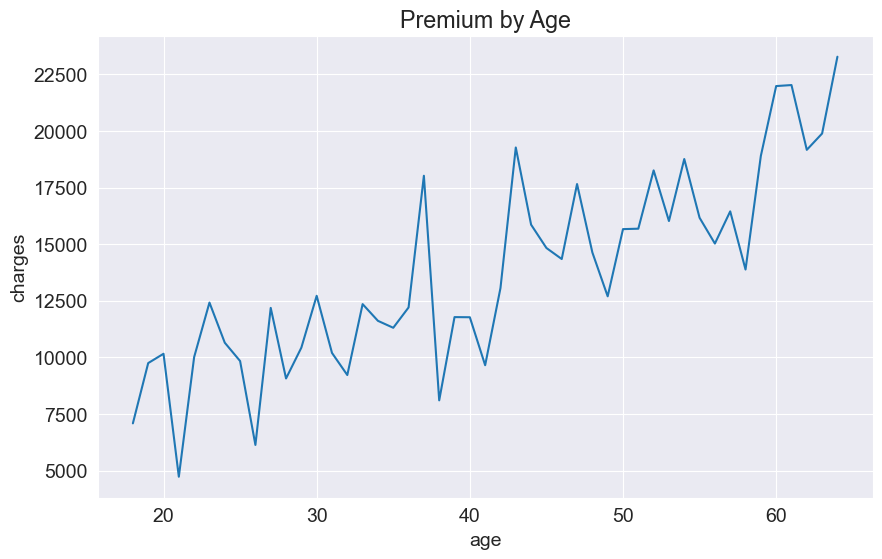

In [10]:
grouped_age = medical_df.groupby('age').mean('charges').reset_index()[['age', 'charges']]
sns.lineplot(grouped_age, x='age', y='charges', markers=True)
plt.title("Premium by Age")

So there are more 18 - 19 yo as the company might be running campaigns and offering lower premium

### Body Mass Index

Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

In [11]:
fig = px.histogram(medical_df, 
                   x='bmi', 
                   marginal='box', 
                   color_discrete_sequence=['red'], 
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

The measurements of body mass index seem to form a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) centered around the value 30, with a few outliers towards the right. It is possible that obese people are more likely to get an insurance
Here's how BMI values can be interpreted ([source](https://study.com/academy/lesson/what-is-bmi-definition-formula-calculation.html)):

![](https://i.imgur.com/lh23OiY.jpg)

### How does BMI and Smoking affect with Charges

In [12]:
px.scatter(medical_df, x='bmi', y='charges', color='smoker', 
           title="Influence of BMI and Smoking on Charges", trendline='ols')

BMI does not seem to affect the charges of premium as much as other factors like smoking does. We can say that a person being a smoker really pumps up the premium charges

### Charges

Let's visualize the distribution of "charges" i.e. the annual medical charges for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the charges for smokers and non-smokers.

In [13]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='smoker', 
                   color_discrete_sequence=['green', 'grey'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

We can make the following observations from the above graph:

* For most customers, the annual medical charges are under \\$10,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
* There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is \\$7300, the median for smokers is close to \\$35,000.

### Smoker

Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [14]:
medical_df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [15]:
px.histogram(medical_df, x='smoker', color='sex', title='Smoker')

It appears that 20% of customers have reported that they smoke and males are more likely to smoke than females.

### Visualising Region, No. of Children, Sex, and Smoker

/Users/nmnsnghl/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



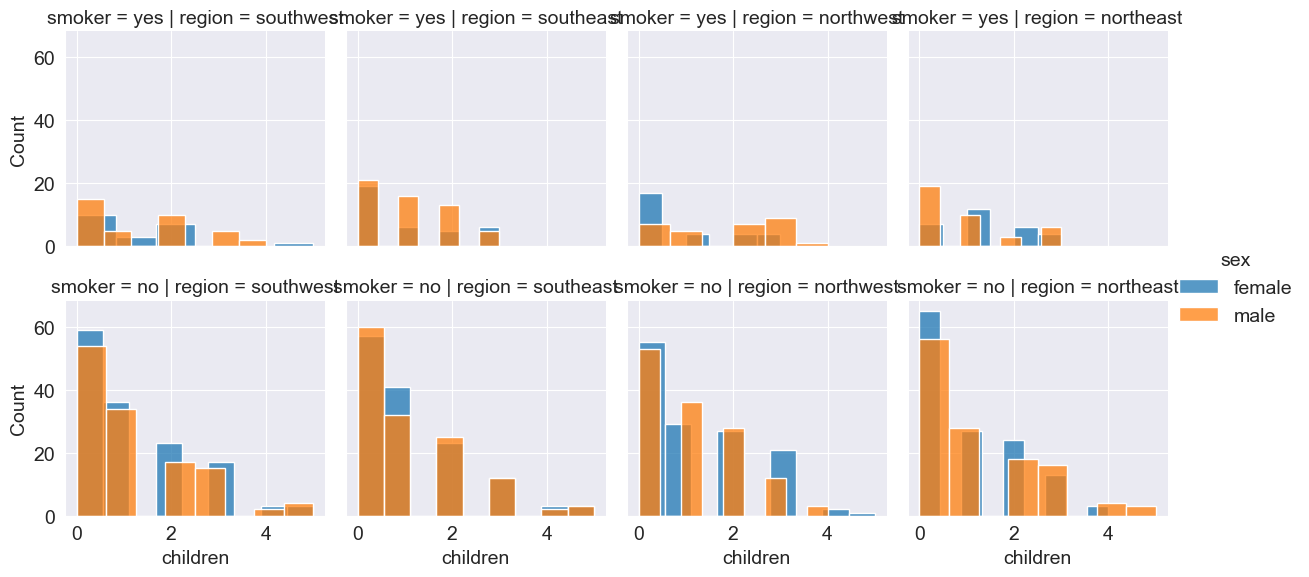

In [16]:
g = sns.FacetGrid(data = medical_df, row='smoker', col = 'region', hue='sex')
g.map(sns.histplot, 'children')
g.add_legend()

From the grid we can make these observations
- Non-smokers with no kids are more likely to purchase insurance
- Southeast region has much more male smokers than female
- Northeast residents taking insurance tend to have no kids. Southwest shows similar trend.

### Age and Charges

Let's visualize the relationship between "age" and "charges" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

In [17]:
fig = px.scatter(medical_df, 
                 x='age', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='Age vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

We can make the following observations from the above chart:

* The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.


* We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

     1. The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical charges compared to others
     
     2. The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".
     
     3. The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.

### Correlation

In [18]:
medical_df.charges.corr(medical_df.age)

0.2990081933306478

In [19]:
medical_df.charges.corr(medical_df.bmi)

0.19834096883362887

To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [20]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = medical_df.smoker.map(smoker_values)
medical_df.charges.corr(smoker_numeric)

0.7872514304984778

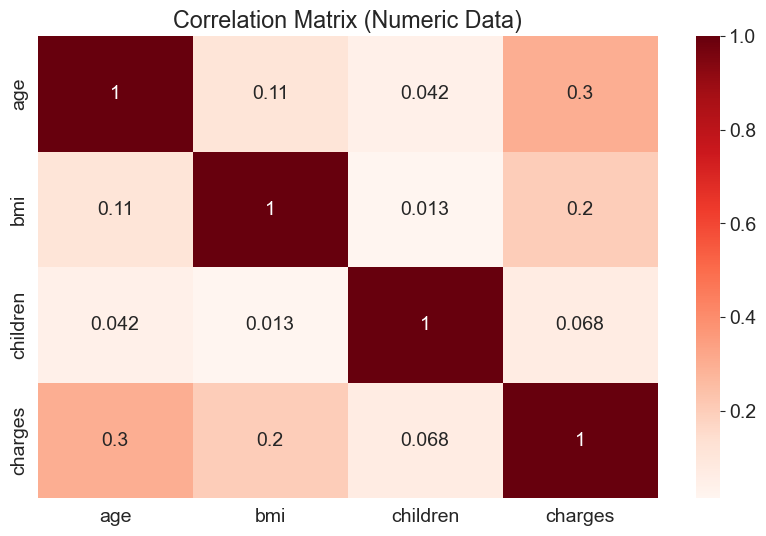

In [21]:
sns.heatmap(medical_df.corr(numeric_only=True), cmap='Reds', annot=True)
plt.title('Correlation Matrix (Numeric Data)');

## Linear Regression

### Processing Categorical Data

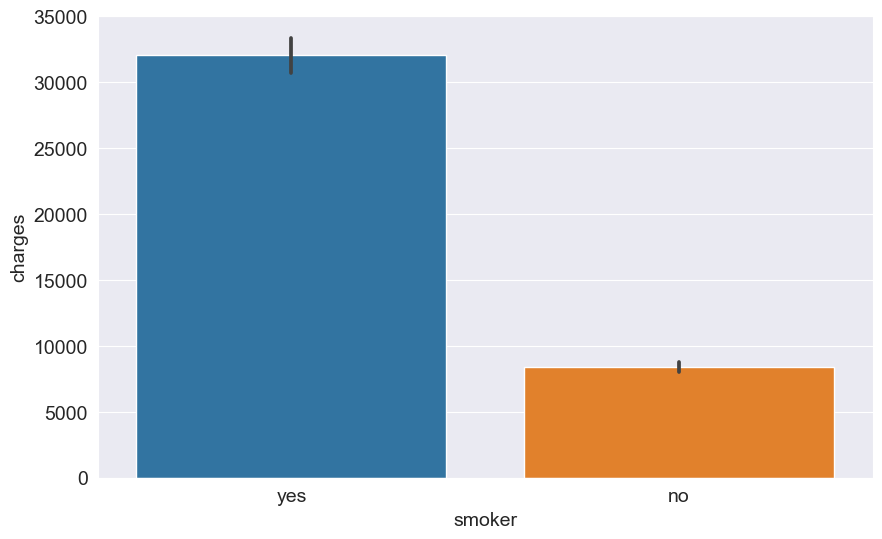

In [22]:
sns.barplot(data=medical_df, x='smoker', y='charges');

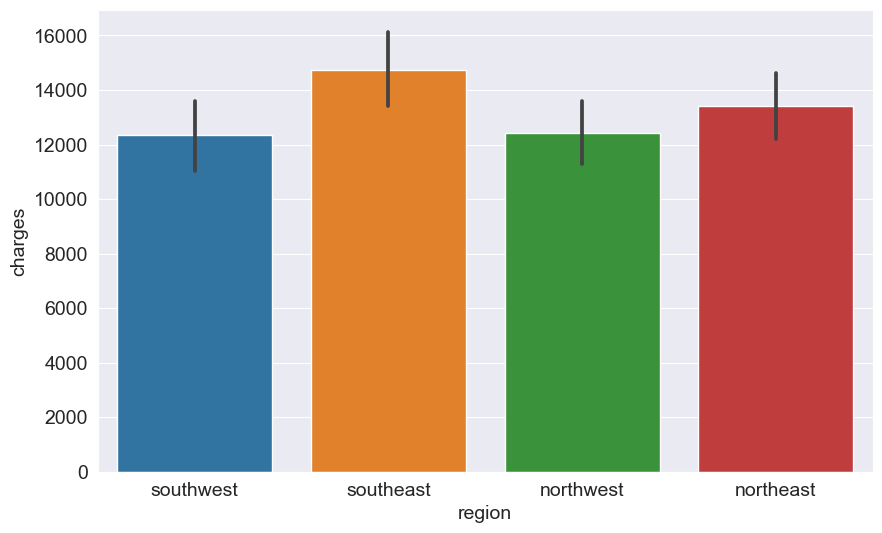

In [23]:
sns.barplot(data=medical_df, x='region', y='charges');

In [24]:
medical_df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [25]:
smoker_codes = {'no': 0, 'yes': 1}
sex_codes = {'female': 0, 'male': 1}

def process_categorical(data: pd.DataFrame, drop: bool = False,
                        num_cols: list = ['age', 'bmi', 'children']) -> pd.DataFrame:

    data = pd.DataFrame(data)
    data.sex = data.sex.map(sex_codes)
    data.smoker = data.smoker.map(smoker_codes)
    data = pd.concat([data, pd.get_dummies(medical_df.region, dtype=int)], axis=1)
    data[num_cols] = StandardScaler().fit_transform(medical_df[num_cols])
    
    if drop:
        data.drop('region', axis=1, inplace=True)
        
    return data

In [26]:
medical_df = process_categorical(medical_df, drop=True)

In [27]:
medical_df.head(2)

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,-1.438764,0,-0.453320,-0.908614,1,16884.9240,0,0,0,1
1,-1.509965,1,0.509621,-0.078767,0,1725.5523,0,0,1,0


In [28]:
x = medical_df[list(filter(lambda x: x!='region', medical_df.columns.to_list()))]
Y = medical_df['charges']

Text(0.5, 1.0, 'Correlation Matrix')

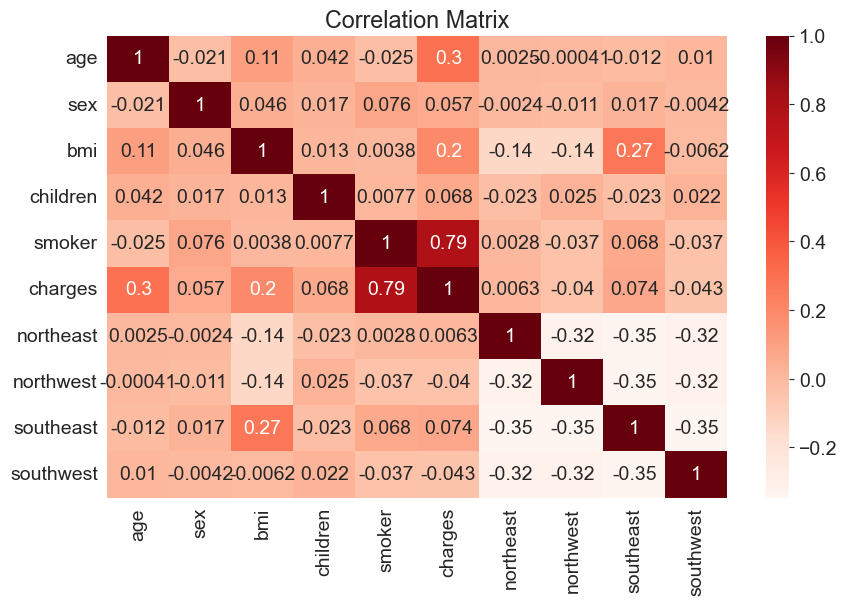

In [29]:
sns.heatmap(x.corr(numeric_only=True), cmap='Reds', annot=True)
plt.title('Correlation Matrix')

There is a strong corr between charges and smoker, and region seems to matter the least

In [30]:
def rmse(targets, predictions):
    return np.sqrt(np.mean(np.square(targets - predictions)))

In [31]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(x, Y, test_size=0.1)

In [32]:
# Create and train the model
model = LinearRegression().fit(inputs_train, targets_train)

# Generate predictions
predictions_test = model.predict(inputs_test)

# Compute loss to evalute the model
loss = rmse(targets_test, predictions_test)
print('Test Loss:', loss)

Test Loss: 7.688443472996275e-12
